In [1]:
from multiprocessing import freeze_support
from mordred import Calculator, descriptors
import os,re,sys,pickle,datetime,time,random,itertools
import warnings
warnings.filterwarnings("ignore")
import numpy as np
np.set_printoptions(threshold=sys.maxsize) #print out full arrays
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import pandas as pd
from scipy import stats
import math
from tqdm import tqdm
import seaborn as sns 
import umap
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA,NMF
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor,GradientBoostingRegressor
from sklearn.feature_selection import SelectKBest,f_regression,mutual_info_regression
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import LogisticRegression,Lasso,LinearRegression,Ridge,ElasticNetCV,ElasticNet,Lars,LassoCV,RidgeCV,LarsCV,LassoLarsCV,LassoLarsIC,OrthogonalMatchingPursuitCV,OrthogonalMatchingPursuit
from sklearn.manifold import TSNE,MDS
from sklearn import metrics
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score,median_absolute_error
from sklearn.model_selection import train_test_split,GridSearchCV,RepeatedKFold,LeaveOneOut
from sklearn.multioutput import MultiOutputRegressor
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
from sklearn.neural_network import MLPClassifier,MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,MinMaxScaler,PolynomialFeatures
from sklearn.svm import LinearSVC,SVR
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import RDConfig
from rdkit.Chem import MolFromSmiles
from rdkit.Chem import PandasTools
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem.Draw import MolsToGridImage
from rdkit.Chem import PropertyMol
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem.Draw.MolDrawing import MolDrawing,DrawingOptions
DrawingOptions.bondLineWidth=1.8
DrawingOptions.includeAtomNumbers=False   #change if you want atom numbering
size = (150, 150)                         # Smaller figures than the default
from rdkit.Chem.Draw.MolDrawing import Font
from rdkit.Chem import rdmolfiles # to be able to save PDB files
from rdkit.Chem import rdFMCS #maximum common subgraph (MCS)
from PIL import Image
randomstate = 42

# Import smiles from an excel file

In [2]:
# (1) export smiles from reaxys search (2) curate with rdkit (3) save into excel file called 'smile.xlsx'

df = pd.read_excel('smiles.xlsx')
smiles = df['smiles'].tolist()
print(smiles)

['CC(C)Oc1ccc(Cl)cc1B(O)O', 'Cc1cc(B(O)O)c(C)cc1F', 'CC1(C)OB(c2ccc(F)cc2)OC1(C)C', 'CC(C)(C)OC(=O)n1cccc1B1OC(C)(C)C(C)(C)O1', 'OB(O)c1ccc(Oc2ccccc2)cc1', 'OB(O)c1cc(Cl)ccc1Cl', 'Nc1cccc(B(O)O)c1', 'CC1(C)OB(c2ccoc2)OC1(C)C', 'COc1cncc(B2OC(C)(C)C(C)(C)O2)c1', 'OB(O)c1ccc2ccncc2c1', 'OB(O)c1ccc(F)c(F)c1', 'OB(O)c1cc(F)ccc1OCc1ccccc1', 'CC1(C)OB(c2cccc(N)c2)OC1(C)C', 'O=Cc1ccsc1B(O)O', 'CCOc1ncccc1B(O)O', 'COc1ccc(B(O)O)c(F)c1F', 'Cc1ccc(C(=O)O)cc1B1OC(C)(C)C(C)(C)O1', 'Cc1ccc(C)c(B(O)O)c1', 'CC1(C)OB(c2ccc(N)cc2F)OC1(C)C', 'CC1(C)OB(c2ccc(Cl)nc2)OC1(C)C', 'CC1(C)OB(c2cc(Cl)cc(Cl)c2)OC1(C)C', 'Cc1ccc(B2OC(C)(C)C(C)(C)O2)s1', 'C=Cc1ccc(B(O)O)cc1', 'CC(C)(C)c1ccc(B2OC(C)(C)C(C)(C)O2)cc1', 'COc1ccc(Br)cc1B(O)O', 'OB(O)c1ccc(F)c(F)c1F', 'CC1(C)OB(c2ccc(CN3CCCCC3)cc2)OC1(C)C', 'CC1(C)OB(c2cccc(CC(N)=O)c2)OC1(C)C', 'CCOc1ccc(B(O)O)cn1', 'COC(=O)c1cccc(-c2ccc(B3OC(C)(C)C(C)(C)O3)cc2)c1', 'COC(=O)c1cncc(B2OC(C)(C)C(C)(C)O2)c1', 'Cc1cc(C(=O)O)ccc1B(O)O', 'COc1ccc(F)c(B(O)O)c1', 'Cc1c(Cl)cccc1B(

# Curate the smiles list (optional)

In [ ]:
# http://rdkit.org/docs/GettingStartedInPython.html - "XX"
# Can base it on substructure search or use rdkit tools to remove based on functionality (not coded below)

patt = Chem.MolFromSmiles('ClC1=CC(Cl)=CC=C1')
matches = []
for i in smiles:
    m = Chem.MolFromSmiles(i)
    if m.HasSubstructMatch(patt):
        matches.append(m)

print(matches)

# Calculate 2d and 3d descriptors

In [3]:
# Embed 3D structure from smiles, optimize with MMFF (UFF also possible), calculate 2D and 3D descriptors
# MMFF optimization will give significantly different values. Sometimes give errors due to bad conformer id:
# just run it again if only a small selection of molecules, comment it out if its a big selection
# list of descriptors = https://mordred-descriptor.github.io/documentation/master/descriptors.html
# http://rdkit.org/docs/GettingStartedInPython.html - "Working with 3D Molecules"
# https://chemistry.stackexchange.com/questions/118460/is-it-possible-to-build-or-embed-the-smiles-representation-of-compounds-in-3d

calc = Calculator(descriptors) # create calculator for all of the mordred descriptors

if __name__ == "__main__":
    freeze_support()

# if curated in step 2: change "smiles" to "matches" and comment out "my_mol = Chem.MolFromSmiles(i)"

molecules = []
for i in smiles:
    my_mol = Chem.MolFromSmiles(i)
    my_mol_with_H=Chem.AddHs(my_mol)
    AllChem.EmbedMolecule(my_mol_with_H)
    AllChem.MMFFOptimizeMolecule(my_mol_with_H)
    molecules.append(my_mol_with_H)

df = calc.pandas(molecules)   # pandas method for calculating multiple molecules (return df)
print(df)
#df.to_excel(r'mordred_descriptors_XX.xlsx', index = True)   # make an excel sheet in the same folder as the script

100%|██████████| 1013/1013 [03:22<00:00,  5.01it/s]


            ABC      ABCGG  nAcid  nBase    SpAbs_A   SpMax_A  SpDiam_A  \
0     10.365564   9.738246      0      0  16.426384  2.337335  4.674671   
1      8.910910   8.583028      0      0  14.004903  2.346955  4.693910   
2     12.630705  11.241455      0      0  18.896779  2.508655  4.811430   
3     16.562115  15.535186      0      0  23.740263  2.529970  4.832745   
4     12.199155   9.978922      0      0  20.509223  2.288246  4.576491   
...         ...        ...    ...    ...        ...       ...       ...   
1008   9.330288   8.586011      0      0  15.366303  2.375305  4.667819   
1009  12.256174  11.264269      0      0  20.003638  2.454542  4.735554   
1010  14.044919  12.629488      0      0  21.279794  2.514409  4.836022   
1011  16.602555  14.388613      0      0  23.548238  2.520187  4.875588   
1012  14.458374  12.359304      0      0  23.634406  2.382253  4.764507   

         SpAD_A   SpMAD_A   LogEE_A  ...      SRW10     TSRW10          MW  \
0     16.426384  1.17

In [4]:
# filter the columns to remove any error messages

columns_to_remove = []

for i in df:
    for j in df[i]:
        if str(j) == '':
            columns_to_remove.append(i)
        if 'invalid' in str(j):
            columns_to_remove.append(i)
        elif 'TRUE' in str(j):
            columns_to_remove.append(i)
        elif 'True' in str(j):
            columns_to_remove.append(i)
        elif 'FALSE' in str(j):
            columns_to_remove.append(i)
        elif 'False' in str(j):
            columns_to_remove.append(i)
        elif 'min' in str(j):
            columns_to_remove.append(i)            
        elif 'max' in str(j):
            columns_to_remove.append(i)          
        elif 'float' in str(j):
            columns_to_remove.append(i)
        elif 'missing' in str(j):
            columns_to_remove.append(i)
        elif 'module' in str(j):
            columns_to_remove.append(i)
        elif 'some' in str(j):
            columns_to_remove.append(i)
        elif 'divide' in str(j):
            columns_to_remove.append(i)
        elif 'there' in str(j):
            columns_to_remove.append(i)
        elif 'bond' in str(j):
            columns_to_remove.append(i)
        elif 'unknown' in str(j):
            columns_to_remove.append(i)
            
columns_to_remove = pd.unique(columns_to_remove).tolist()
#print(columns_to_remove)
print('\n',len(columns_to_remove),'columns removed\n')

df2 = df.drop(columns_to_remove, axis=1)
print(df2)
#df2.to_excel(r'novartis boron mordred.xlsx', index = True)


 288 columns removed

            ABC      ABCGG  nAcid  nBase    SpAbs_A   SpMax_A  SpDiam_A  \
0     10.365564   9.738246      0      0  16.426384  2.337335  4.674671   
1      8.910910   8.583028      0      0  14.004903  2.346955  4.693910   
2     12.630705  11.241455      0      0  18.896779  2.508655  4.811430   
3     16.562115  15.535186      0      0  23.740263  2.529970  4.832745   
4     12.199155   9.978922      0      0  20.509223  2.288246  4.576491   
...         ...        ...    ...    ...        ...       ...       ...   
1008   9.330288   8.586011      0      0  15.366303  2.375305  4.667819   
1009  12.256174  11.264269      0      0  20.003638  2.454542  4.735554   
1010  14.044919  12.629488      0      0  21.279794  2.514409  4.836022   
1011  16.602555  14.388613      0      0  23.548238  2.520187  4.875588   
1012  14.458374  12.359304      0      0  23.634406  2.382253  4.764507   

         SpAD_A   SpMAD_A   LogEE_A  ...      SRW10     TSRW10          MW  

# Clustering

In [6]:
# if an error due to NaN arises, go to section 6

df2.index = df2.index.astype(int)
df2.dropna(axis=0,inplace=True)
X_all = np.array(df2)
X_all_ids = np.array(df2.index)
scaler = StandardScaler()
scaler.fit(X_all)
X_all_sc = scaler.transform(X_all)

pca = PCA(n_components=10) # choose number of PCs
pca.fit(X_all_sc)
X_all_pca    = pca.transform(X_all_sc)
pca_score = pca.explained_variance_ratio_
pca_values = pca.singular_values_
print('Variance explained by individual PCs:',pca.explained_variance_ratio_,'\n')
print('Total variance explained by PCs:',np.sum(pca.explained_variance_ratio_))

Variance explained by individual PCs: [0.39004574 0.09079703 0.05638234 0.03853555 0.02745237 0.02501883
 0.02177118 0.01940144 0.01802499 0.01655338] 

Total variance explained by PCs: 0.7039828481149896


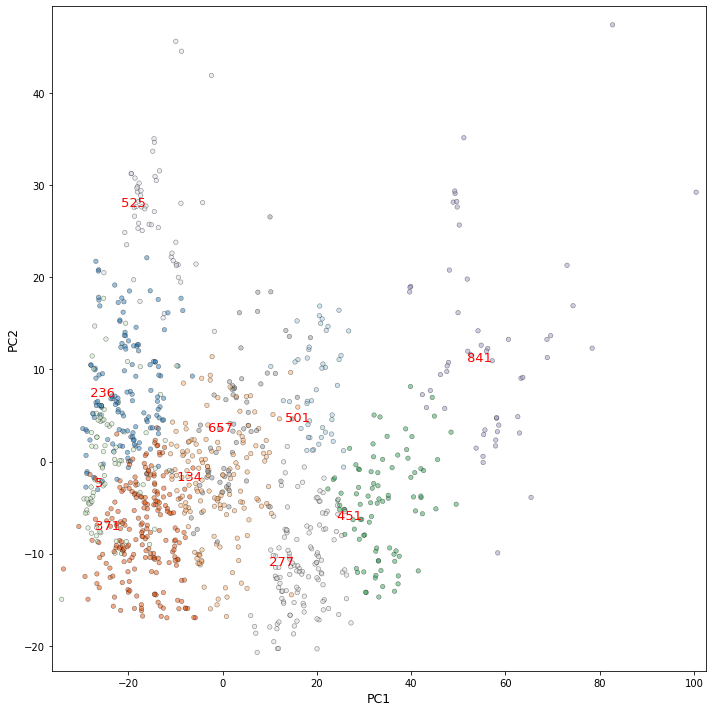

In [8]:
nclusters = 10

####################################################################################
X_use = X_all_pca
X_main_ids = X_all_ids
X_kmeans = X_use                 #array containing the 4 PC values for each individual ligand
kmeans = KMeans(n_clusters=nclusters, random_state=42).fit(X_kmeans)

dists = []                       #distances for each ligand from cluster centre
for x in range(len(X_kmeans)):
    delta = [X_kmeans[x,i]-kmeans.cluster_centers_[kmeans.labels_[x],i] for i in range(len(X_kmeans[0]))]
    dist = np.linalg.norm(delta)
    dists.append(dist)

clusters = {}                     #key = cluster number, value = indices of the ligands in that cluster
clusterdists = {}                 #key = cluster number, value = distance of ligand to the centroid
clustermins = []                  #indices of the ligands closest to the cluster centre
clusterorders_dict = {}           #key = cluster, values = indices for ligands ordered by distance from centroid
clusterorders = np.zeros(X_kmeans.shape[0]) #ligand IDs in order of each ligand’s distance to the cluster centre

for x in range(nclusters):
    clusters[x] = [i for i in range(len(kmeans.labels_)) if kmeans.labels_[i] == x]
    clusterdists[x] = [dists[i] for i in clusters[x]]
    clustermins.append(clusters[x][clusterdists[x].index(min(clusterdists[x]))])
    clusterorders_dict[x] = [y for _,y in sorted(zip(clusterdists[x],clusters[x]))]
    for i in clusters[x]:
        clusterorders[i] = clusterorders_dict[x].index(i)+1
        
f_ind_1 = 0
f_ind_2 = 1
x_min, x_max = X_kmeans[:, f_ind_1].min() - 2, X_kmeans[:, f_ind_1].max() + 2
y_min, y_max = X_kmeans[:, f_ind_2].min() - 2, X_kmeans[:, f_ind_2].max() + 2
plt.figure(figsize=(10,10))
extent = [x_min,x_max,y_min,y_max]
plt.xticks(fontsize=10) 
plt.yticks(fontsize=10)
plt.xlabel(r"PC1",fontsize=12.5)
plt.ylabel(r"PC2",fontsize=12.5)
plt.locator_params(axis='y', nbins=8)
plt.xlim(x_min,x_max)
plt.ylim(y_min,y_max)

####################################################################################

### coloring in the clusters
mapping = kmeans.labels_
cMap = "tab20c"
plt.scatter(X_kmeans[:,f_ind_1], X_kmeans[:,f_ind_2],c=mapping,cmap=cMap,alpha=.5,marker=".",s=80,edgecolor="black",linewidth=0.5)

main_row_id = list(enumerate(X_main_ids))
clusters_with_ids = {}
for i in range(0,len(clusters)):
    emptylist = []
    for j in range(0,len(clusters[i])):
        emptylist.append(main_row_id[clusters[i][j]][1])
    clusters_with_ids[i] = emptylist
    
### plotting all ligand ids    
#for i in range(0,nclusters):
#    for j in range(0,len(clusters_with_ids[i])):
#        plt.text(X_use[clusters[i][j],f_ind_1],X_use[clusters[i][j],f_ind_2]," "+str(clusters_with_ids[i][j]),color="blue",fontsize=12,ha="left")

### plotting centroid labels
for i in range(0,nclusters):
    for j in range(0,len(clusters_with_ids[i])):
        if clusters[i][j] in clustermins:
            plt.text(X_use[clusters[i][j],f_ind_1],X_use[clusters[i][j],f_ind_2]," "+str(clusters_with_ids[i][j]),color="red",fontsize=13,ha="right")
    
plt.tight_layout()
#plt.savefig("ligandpcaall.png",dpi=300)
plt.show()     

# Structures for the samples closest to the cluster centroids

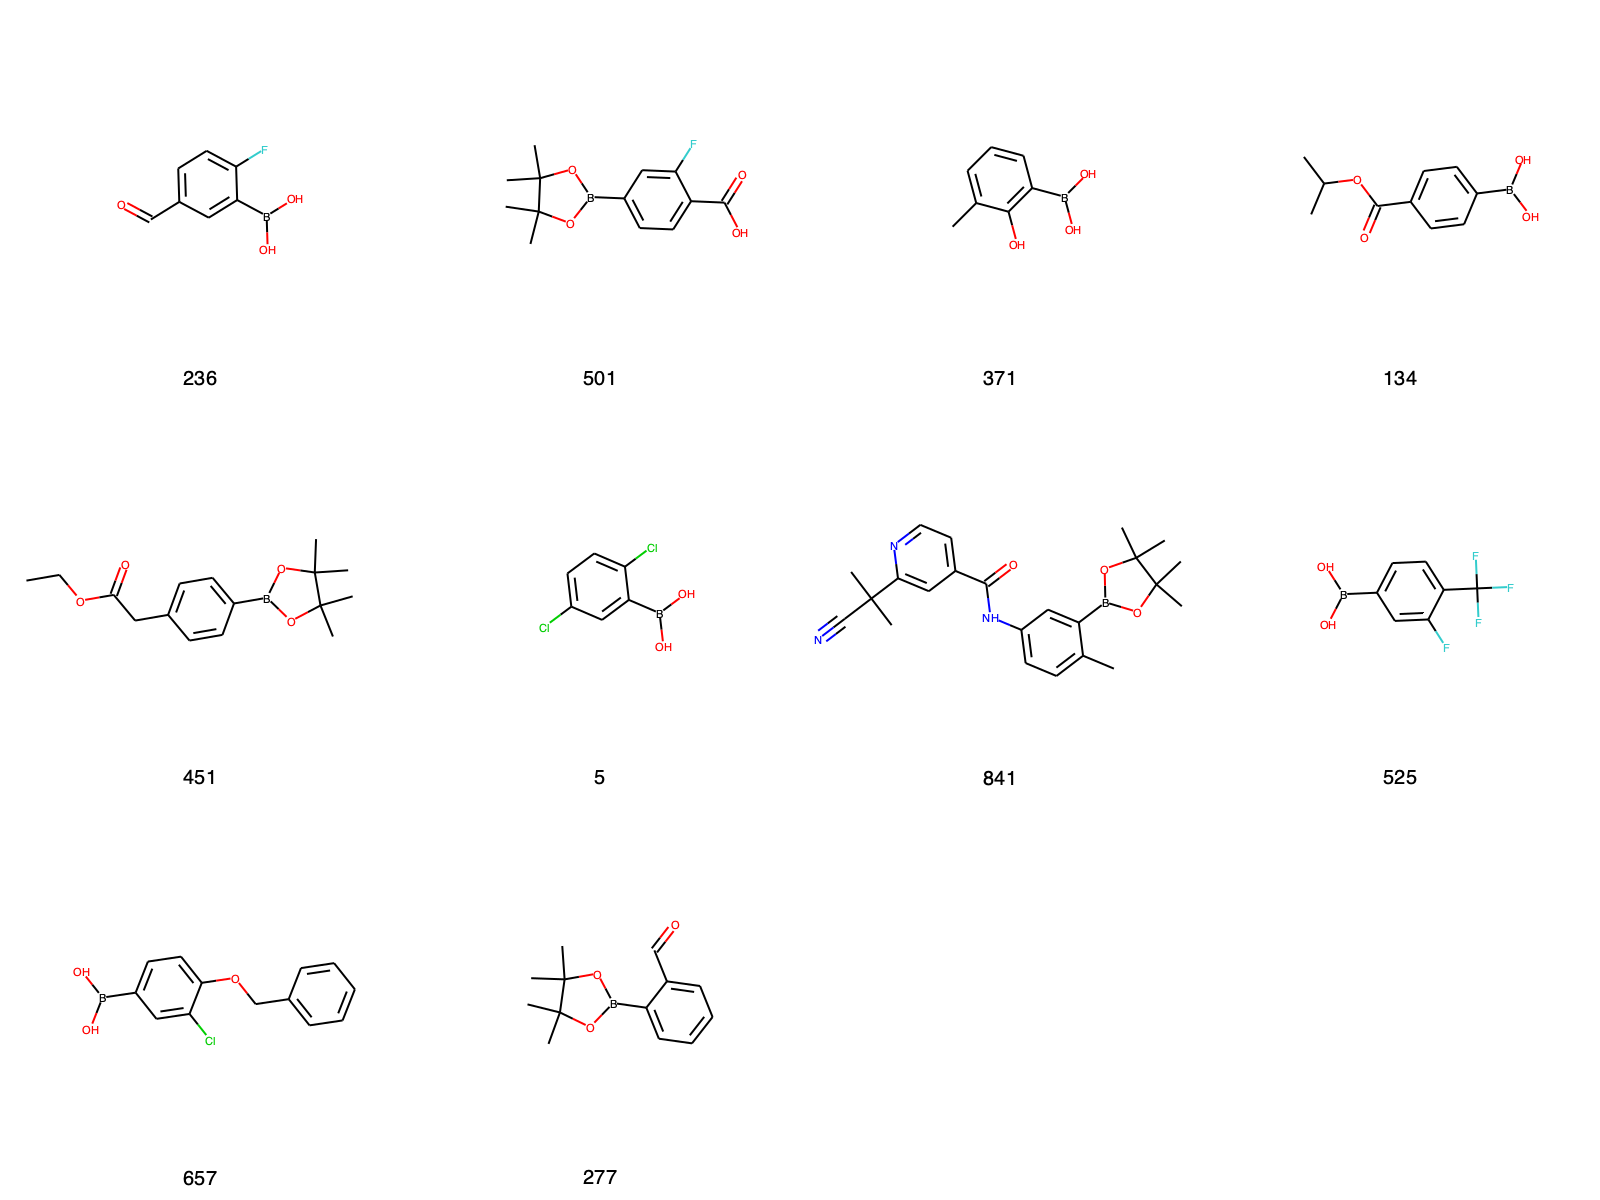

In [9]:
closest_to_centroids = []
for i in clustermins:
    closest_to_centroids.append(smiles[i])

count=0
subms = []
for i in closest_to_centroids:
    x = Chem.MolFromSmiles(i)
    #tmp=AllChem.Compute2DCoords(x)     # was giving issues with some ligands, don't think its required
    count+=1
    subms.append(x)

### cluster and ligand id for main set = clusters_with_ids, comes from section 7a, is a dict
clustermins_str = [str(i) for i in clustermins]
my_labels = clustermins_str  
        
molsPerRow = 4          # molecules per row
subImgSize= (400,400)   # image quality for the smiles

nRows = -(count // -molsPerRow)   # // = floor division: gives lowest interger after performing the division

fullSize = (molsPerRow * subImgSize[0], nRows * subImgSize[1]) # defining width and height

img = rdMolDraw2D.MolDraw2DCairo(fullSize[0],fullSize[1],subImgSize[0], subImgSize[1]) # setting up the image
img.drawOptions().legendFontSize=20                        # font size
img.DrawMolecules(subms[:],legends=my_labels[:])           # adding images and corresponding labels (must be str)
img.SetFontSize(100)                                       # not used at the moment
img.FinishDrawing()                                        # finish the image

# %s acts a placeholder for a string while %d acts as a placeholder for a number.
# their associated values are passed in via a tuple using the % operator
# wb+ = opens a file for both writing and reading in binary format. Overwrites the existing file if the file exists.
# if the file does not exist, creates a new file for reading and writing.

with open('centroids.png','wb+') as wfp:             # opening a png file, goes into current folder
    wfp.write(img.GetDrawingText())                  # saving in the image
Image.open('centroids.png')                          # opening it in the notebook

# Finding other NaNs in X_all_sc

In [ ]:
for i in range(0,len(X_all_sc)):
    if np.isnan(X_all_sc[i]).any():
        for j in range(0,len(X_all_sc[i])):
            if np.isnan(X_all_sc[i][j]):
                print('sample',i,'contains NaN for descriptor',j)